# Lagos House Predictor

Predicting the price of homes in Lagos based off data scraped from [PropertPro.ng](https://www.propertypro.ng/property-for-sale/in/lagos)

___

* Type of Machine Learning Method
    * Supervised Learning
        * Regression
            * LightGBM Regressor
                * MAE - ₦45.9 million
___
* Dataset Used
     * Data was scraped from [PropertPro.ng](https://www.propertypro.ng/property-for-sale/in/lagos), code for the script is found at Web Scraper notebook

## Import Dataset

We first would import the necessary libraries we need at the moment, we will import others as when they are needed

In [93]:
import numpy as np # for numerical analysis
import pandas as pd # for data manipulation
import joblib # for saving tools for future use

# for plotting graphs
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("darkgrid")

Importing train, test and validation dataset

In [94]:
train = pd.read_csv("clean/train.csv")
test = pd.read_csv("clean/test.csv")
validation = pd.read_csv("clean/validation.csv")

In [95]:
train.head()

,Serviced,Newly Built,Furnished,Bedrooms,Bathrooms,Toilets,Neighborhood_Opebi,Neighborhood_Other Lekki,Neighborhood_Adeniyi Jones,Neighborhood_Lekki Phase 1,...,Neighborhood_Awolowo Way,Neighborhood_Agidingbi,Type_Semi Detached Duplex,Type_Detached Duplex,Type_Terraced Duplex,City_Ikeja,City_Lekki,City_Ikoyi,City_Victoria Island,Price
0,0,0,0,-0.481408,-0.582738,-0.170592,1,0,0,0,...,0,0,1,0,0,1,0,0,0,90000000.0
1,0,0,0,-0.481408,-0.582738,0.736067,0,1,0,0,...,0,0,0,1,0,0,1,0,0,125000000.0
2,0,0,0,4.529648,3.233198,2.549384,0,0,1,0,...,0,0,0,1,0,1,0,0,0,300000000.0
3,0,0,0,-0.481408,-0.582738,-1.077250,0,0,0,1,...,0,0,1,0,0,0,1,0,0,180000000.0
4,0,1,0,0.771356,1.325230,-0.170592,0,1,0,0,...,0,0,0,1,0,0,1,0,0,55000000.0


We can see from the data above we have 44 features as our Target Variable is **Price**

In [96]:
train.shape

(8408, 46)

## Preprocessing of Validation data

Let's do the necessary splits

In [97]:
X_train = train.drop(["Price"], axis=1)
y_train = train["Price"]

Here are the categorical and numerical features that need to be preprocessed

In [98]:
category = ['Neighborhood', 'Type', 'City']
numerical = ['Bathrooms', 'Bedrooms', 'Toilets']

Importing tools needed for preprocessing

In [99]:
encoder = joblib.load("tools/encoder_joblib")
imputer = joblib.load("tools/imputer_joblib")
scaler = joblib.load("tools/scaler_joblib")

Splitting validation data

In [100]:
X_val = validation.drop(["Price"], axis=1)
y_val = validation["Price"]

Here we are preprocessing the validation data so it can be used by the machine learning model

In [101]:
X_val[category] = imputer.transform(X_val[category]) # imputing missing values
X_val[numerical] = scaler.transform(X_val[numerical]) # scaling numerical values 
X_val = encoder.transform(X_val) # enconding categorical values

## Model Building and Validation

Lets import the necessary machinne learning models that would be used for fitting the data

In [102]:
from sklearn.ensemble import RandomForestRegressor # Random Forest
from xgboost import XGBRegressor # XGBoost
from sklearn.svm import SVR # SVM
from sklearn.neighbors import KNeighborsRegressor # KNN
from lightgbm import LGBMRegressor # LightGBM

### Random Forest

Here we are initializing the model, then fitting the data and making prediction on the validation data

In [103]:
rf = RandomForestRegressor(random_state=51) 
rf.fit(X_train, y_train)
rf_predictions = rf.predict(X_val)

### XGBoost

In [104]:
xgb = XGBRegressor(random_state=51, n_estimators=10, max_depth=5)
xgb.fit(X_train, y_train)
xgb_predictions = xgb.predict(X_val)

### LightGBM

In [105]:
lgb = LGBMRegressor(random_state=51, n_jobs=-1, boosting_type="dart", num_leaves=50, max_depth=7, subsample_for_bin=200, min_child_samples=16)
lgb.fit(X_train, y_train)
lgb_predictions = lgb.predict(X_val)

### SVM

In [106]:
svm = SVR()
svm.fit(X_train, y_train)
svm_predictions = svm.predict(X_val)

### KNN

In [107]:
knn = KNeighborsRegressor(n_neighbors=16, algorithm="ball_tree")
knn.fit(X_train, y_train)
knn_predictions = knn.predict(X_val)

### Model Performance on Validation data

Here we are checking the performance of the machine learning models on the validation data

In [108]:
# import MAE metric
from sklearn.metrics import mean_absolute_error

In [109]:
print(f"Random Forests: {mean_absolute_error(y_val, rf_predictions) / 1e6}")
print(f"XGBoost: {mean_absolute_error(y_val, xgb_predictions) / 1e6}")
print(f"LightGBM: {mean_absolute_error(y_val, lgb_predictions) / 1e6}")
print(f"SVM: {mean_absolute_error(y_val, svm_predictions) / 1e6}")
print(f"KNN: {mean_absolute_error(y_val, knn_predictions) / 1e6}")

Random Forests: 48.813402195445256
XGBoost: 45.57799470233001
LightGBM: 44.631932426370426
SVM: 65.83482951681282
KNN: 47.52342858559201


## Final Model Building and Prediction on Test Data

### Preprocessing on Test Data

Merge Train and Validation data to improve performance

In [110]:
validation = pd.concat([X_val, y_val], axis=1)
join_df = pd.concat([train, validation]).sample(frac=1)
X = join_df.drop("Price", axis=1)
y = join_df["Price"]

Data Split

In [111]:
X_train = join_df.drop(["Price"], axis=1)
y_train = join_df["Price"]

Preprocessing Test Data

In [112]:
X_test = test.drop(["Price"], axis=1)
y_test = test["Price"]

In [113]:
X_test[category] = imputer.transform(X_test[category])
X_test[numerical] = scaler.transform(X_test[numerical])
X_test = encoder.transform(X_test)

### Random Forest

In [136]:
rf = RandomForestRegressor(random_state=51, max_depth=10)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, random_state=51)

In [137]:
rf_predictions = rf.predict(X_test)

### XGBoost

In [138]:
xgb = XGBRegressor(random_state=51, n_estimators=10, max_depth=5)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=10, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=51,
             reg_alpha=0, reg_lambda=1, ...)

In [139]:
xgb_predictions = xgb.predict(X_test)

### LightGBM

In [140]:
lgb = LGBMRegressor(random_state=51, n_jobs=-1, boosting_type="dart", subsample_for_bin=200, num_leaves=40, n_estimators=160, min_child_samples=21, max_depth=17)
lgb.fit(X_train, y_train)

LGBMRegressor(boosting_type='dart', max_depth=17, min_child_samples=21,
              n_estimators=160, num_leaves=40, random_state=51,
              subsample_for_bin=200)

In [141]:
lgb_predictions = lgb.predict(X_test)

### SVM

In [146]:
svm = SVR()
svm.fit(X_train, y_train)

SVR()

In [147]:
svm_predictions = svm.predict(X_test)

### KNN

In [144]:
knn = KNeighborsRegressor(n_neighbors=16, algorithm="ball_tree")
knn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='ball_tree', n_neighbors=16)

In [145]:
knn_predictions = knn.predict(X_test)

### Model Performance on Test data

Here we are checking the performance of the machine learning models on the test data

In [119]:
print(f"Random Forests: {mean_absolute_error(y_test, rf_predictions) / 1e6}")
print(f"XGBoost: {mean_absolute_error(y_test, xgb_predictions) / 1e6}")
print(f"LightGBM: {mean_absolute_error(y_test, lgb_predictions) / 1e6}")
print(f"SVM: {mean_absolute_error(y_test, svm_predictions) / 1e6}")
print(f"KNN: {mean_absolute_error(y_test, knn_predictions) / 1e6}")

Random Forests: 47.981976310101885
XGBoost: 47.66071288051751
LightGBM: 46.281797674950845
SVM: 68.47029698827649
KNN: 49.07626288582097


Renaming LightGBM to final model 

In [120]:
model = lgb

## Case Prediction

We would create a function to help us perform predictions from new data 

In [121]:
def predict_house(data):
    test = pd.DataFrame([data])
    category = ['Neighborhood', 'Type', 'City']
    numerical = ['Bathrooms', 'Bedrooms', 'Toilets']

    test[category] = imputer.transform(test[category])
    test[numerical] = scaler.transform(test[numerical])
    test = encoder.transform(test)

    prediction = model.predict(test)[0]
    
    print(f"The price of the requested property is {prediction / 1e6:.0f} million naira")

Let's assume we want to buy a newly built, serviced, unfurnished detached duplex in Osapa London, Lekki,that has 4 Bedrooms each with bathrooms, and a guest toilet

In [122]:
new_input = {
    "Serviced" : 1,
    "Newly Built" : 1,
    "Furnished" : 0,
    "Bedrooms" : 4,
    "Bathrooms" : 4,
    "Toilets" : 5,
    "Neighborhood" : "Osapa London",
    "Type" : "Detached Duplex",
    "City" : "Lekki"
}

predict_house(new_input)

The price of the requested property is 112 million naira


Semi-Detached House in Banana Island, Ikoyi with 5 bedroom and bathrooms with 6 toilets

In [123]:
new_input = {
    "Serviced" : 0,
    "Newly Built" : 0,
    "Furnished" : 0,
    "Bedrooms" : 5,
    "Bathrooms" : 5,
    "Toilets" : 6,
    "Neighborhood" : "Banana Island",
    "Type" : "Semi Detached Duplex",
    "City" : "Ikoyi"
}

predict_house(new_input)

The price of the requested property is 347 million naira


### Important Features
We check for the features that are the most important features for determining the house prices
* Newly built
* Bedrooms
* Toilets
* Bathrooms

In [124]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

In [125]:
importance_df.head(10)

,feature,importance
3,Bedrooms,606
4,Bathrooms,487
5,Toilets,460
39,Type_Detached Duplex,415
1,Newly Built,407
9,Neighborhood_Lekki Phase 1,351
18,Neighborhood_GRA,346
43,City_Ikoyi,316
13,Neighborhood_Ikate,302
44,City_Victoria Island,279


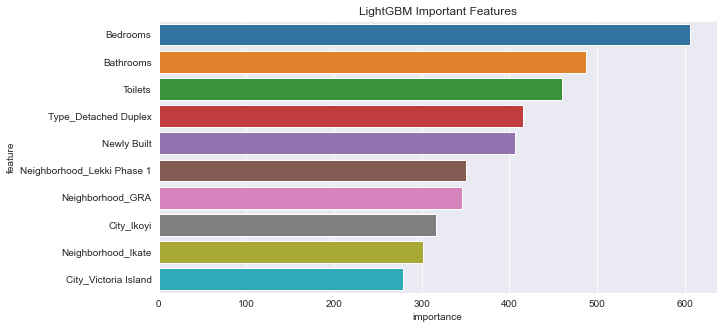

In [126]:
plt.figure(figsize=[10,5])
plt.title("LightGBM Important Features")
sns.barplot(data=importance_df.head(10), x="importance", y="feature");

In [127]:
xgb_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb.feature_importances_
}).sort_values('importance', ascending=False)

In [128]:
importance_df.head(10)

,feature,importance
3,Bedrooms,606
4,Bathrooms,487
5,Toilets,460
39,Type_Detached Duplex,415
1,Newly Built,407
9,Neighborhood_Lekki Phase 1,351
18,Neighborhood_GRA,346
43,City_Ikoyi,316
13,Neighborhood_Ikate,302
44,City_Victoria Island,279


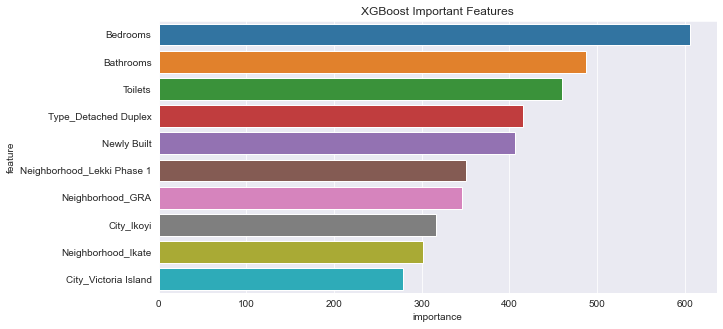

In [129]:
plt.figure(figsize=[10,5])
plt.title("XGBoost Important Features")
sns.barplot(data=importance_df.head(10), x="importance", y="feature");

In [130]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

In [131]:
importance_df.head(10)

,feature,importance
3,Bedrooms,0.310359
43,City_Ikoyi,0.280807
9,Neighborhood_Lekki Phase 1,0.062894
39,Type_Detached Duplex,0.046530
5,Toilets,0.042742
44,City_Victoria Island,0.034378
4,Bathrooms,0.031908
18,Neighborhood_GRA,0.025592
15,Neighborhood_Osapa London,0.023718
1,Newly Built,0.021720


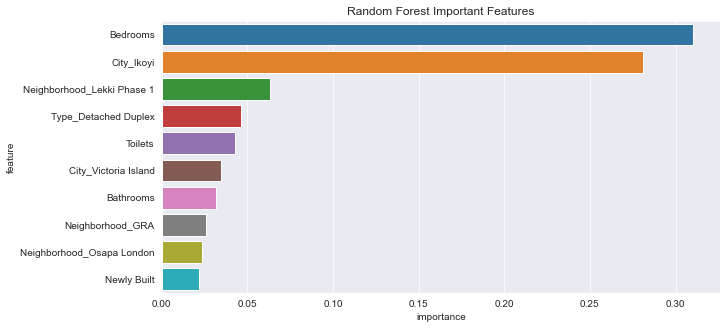

In [132]:
plt.figure(figsize=[10,5])
plt.title("Random Forest Important Features")
sns.barplot(data=importance_df.head(10), x="importance", y="feature");

## Save Model

Saving the model for model deployment

In [133]:
import joblib

In [135]:
# joblib.dump(model, "tools/model_joblib")

['tools/model_joblib']